To-Do:
- develop an autocomplete API that allows users to pick findings in the HPO database
- find groups of findings that add up to effectively pathognominic

## Given a set of findings, return the most likely rare diseases

Number of diseases imported from the ORDO database: 10,735  
Number of phenotypes imported from the HPO database: 10,653  
Number of disease-phenotype relations imported from the HOOM database: 108,638  

In [2]:
import getpass
import pandas as pd
import time
from neo4j import GraphDatabase

In [3]:
password = getpass.getpass("\nPlease enter the Neo4j database password to continue \n")

driver=GraphDatabase.driver(uri="bolt://localhost:7687", auth=('neo4j',password))
session=driver.session()


Please enter the Neo4j database password to continue 
 ············


In [25]:
# Get a count of the number of rare diseases associated with each human phenotype entity, 
# and set that number as a property of the human phenotype entity
query = '''
MATCH (h:HPOentity)-[:ASSOC_WITH]-(o:OrphEntity)
WITH h, count(o) as Number
SET h.number_assoc_rare_diseases = Number
RETURN h.name, h.number_assoc_rare_diseases AS freq
ORDER BY freq DESC
'''
data = session.run(query)
hpo_frequencies = pd.DataFrame([dict(record) for record in data])

hpo_frequencies

,h.name,freq
0,Seizure,1024
1,Intellectual disability,862
2,Short stature,783
3,Global developmental delay,736
4,Microcephaly,590
...,...,...
6711,Abnormal molar morphology,1
6712,Abnormality of permanent molar morphology,1
6713,Localized hypoplasia of dental enamel,1
6714,Hypomature dental enamel,1


<AxesSubplot:>

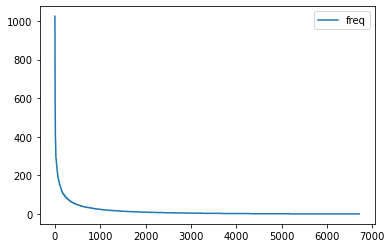

In [44]:
hpo_frequencies.plot()

In [30]:
# Get the maximum and minimum estimated prevalence values for each disease
# and set these as upper and lower estimate properties on each disease
query = '''
MATCH (n:OrphEntity)
UNWIND [n.point_prevalence, n.birth_prevalence, n.lifetime_prevalence] AS prev
WITH max(prev) AS max_prev, min(prev) AS min_prev, n
SET n.prevalence_estimate_upper = max_prev, n.prevalence_estimate_lower = min_prev
RETURN n.name, n.prevalence_estimate_upper, n.prevalence_estimate_lower
'''
data = session.run(query)
disease_prevalences = pd.DataFrame([dict(record) for record in data])
disease_prevalences

,n.name,n.prevalence_estimate_upper,n.prevalence_estimate_lower
0,"48,XXYY syndrome",0.000050,0.000050
1,Ataxia-telangiectasia,0.000175,0.000028
2,Ocular albinism with late-onset sensorineural ...,0.000001,0.000001
3,Reticular perineurioma,NaN,NaN
4,Sclerosing perineurioma,NaN,NaN
...,...,...,...
10730,Intermediate DEND syndrome,NaN,NaN
10731,Brill-Zinsser disease,NaN,NaN
10732,Relapsing epidemic typhus,NaN,NaN
10733,Complex regional pain syndrome type 2,NaN,NaN


In [32]:
# Find the number of phenotype relations which constitute diagnostic criteria
query = '''
MATCH (n:HPOentity)-[r:ASSOC_WITH]-(o:OrphEntity)
RETURN r.diagnostic_criterion_attribute, count(r)
'''
data = session.run(query)
pd.DataFrame([dict(record) for record in data])

,r.diagnostic_criterion_attribute,count(r)
0,None,107457
1,Exclusion_DC,633
2,Criterion_DC,541
3,Pathognomomic_DC,7


In [43]:
# Find the number of diseases with at least one diagnostic criterion
query = '''
MATCH (n:HPOentity)-[r:ASSOC_WITH]-(o:OrphEntity)
RETURN r.diagnostic_criterion_attribute, count(distinct(o))
'''
data = session.run(query)
pd.DataFrame([dict(record) for record in data])

,r.diagnostic_criterion_attribute,count(distinct(o))
0,None,4342
1,Exclusion_DC,319
2,Criterion_DC,170
3,Pathognomomic_DC,7


In [39]:
# Examine the pathognomonic findings and their corresponding diseases
query = '''
MATCH (n:HPOentity)-[r:ASSOC_WITH]-(o:OrphEntity)
WHERE r.diagnostic_criterion_attribute = 'Pathognomomic_DC'
RETURN n.name AS Finding, o.name AS Disease
'''
data = session.run(query)
pd.DataFrame([dict(record) for record in data])

,Finding,Disease
0,Ovarian gonadoblastoma,Gonadoblastoma
1,Ganglioneuroma,Ganglioneuroma
2,Remnants of the hyaloid vascular system,Persistent hyperplastic primary vitreous
3,Adrenocortical cytomegaly,Beckwith-Wiedemann syndrome
4,True hermaphroditism,"46,XY ovotesticular disorder of sex development"
5,Pituitary carcinoma,Pituitary carcinoma
6,Recurrent singultus,Chronic hiccup


Of the pathognomonic findings above, only adrenocortical cytomegaly may provide a non-obvious diagnosis. Looks like using pathognomonic findings from this dataset won't be much help in identifying kids with rare disease. Let's see where a more probabilistic approach takes us.

## Challenges

Given the findings associated with a single disease, identify which disease is the most likely diagnosis.  
Given the findings for two diseases mixed up in a single list, identify which two diseases are the most likely and which of the findings go with each disease.  
Given the findings for n diseases, find the minimum set of diseases which can account for the maximum number of findings.  
Can we find a kid with Alstrom syndrome based on these findings: Dilated cardiomypathy, obesity, visual abnormality, +/- diabetes

Factors which increase the likelihood of a disease:
- the number of findings in the given list which match to a disease
- a higher prevalence of the disease in the general population

Factors which decrease the likelihood of a disease:
- findings in a given list which have "Exclusion_DC" in their connection to a disease
- the absence of findings which have a high approx_frequency of association between the finding and a disease

Factors which increase the weight of any given finding:
- a higher specificity of a given finding for a disease
- presence of the "Criterion_DC" or "Pathognomomic_DC" in their connection to a disease

## Approach
1. Get a list of diseases which have at least one finding in the list of given findings, and which are not excluded by the given findings
2. Calculate the likelihood of each disease:  
Likelihood of disease = (disease prevalence) X (specificity of present finding 1 + ...specificity of present finding n) X (number of "Criterion_DC" findings) / (approx_frequency of absent finding 1 + ...approx_frequency of absent finding n)  
-or-  
Likelihood of disease = (disease prevalence) X (number of findings positive in this patient) / (total number findings associated with the disease)  
3. Sort the list from most likely to least

In [184]:
# Get lists of findings associated with a couple of diseases
query = '''
MATCH (h:HPOentity)-[r:ASSOC_WITH]->(d:OrphEntity)
WHERE d.umls_id IN ["C2930971", "C0018854", "C1969443"]
RETURN d.name AS Disease, collect(h.umls_id) as Findings'''
data = session.run(query)
disease_example = pd.DataFrame([dict(record) for record in data])
disease_example

,Disease,Findings
0,Gamma-heavy chain disease,"[C0442874, C3806482, C0015967, C0015672, C0427..."
1,Long chain 3-hydroxyacyl-CoA dehydrogenase def...,"[C0442874, C4021768, C4020885, C1856438, C0015..."
2,Mitochondrial trifunctional protein deficiency,"[C0746674, C0023380, C0149721, C1849686, C1836..."
3,Hajdu-Cheney syndrome,"[C0442874, C0003803, C0423113, C2315100, C1866..."


In [226]:
dz_1_findings = disease_example['Findings'][0]
dz_2_findings = disease_example['Findings'][1]
dz_3_findings = disease_example['Findings'][2]
dz_4_findings = disease_example['Findings'][3]
dz_1_2_3_4_findings = list(set(dz_1_findings + dz_2_findings + dz_3_findings + dz_4_findings))

len(dz_1_2_3_4_findings)

160

In [9]:
# Get a list of diseases which have at least one finding in the list of given findings,
# and which are not excluded by the given findings
query = '''
MATCH (given_f:HPOentity)-[r:ASSOC_WITH]->(d:OrphEntity) 
MATCH (total_f:HPOentity)-[:ASSOC_WITH]->(d)
WHERE given_f.umls_id IN {finding_list} AND (r.diagnostic_criterion_attribute IS NULL OR NOT r.diagnostic_criterion_attribute = 'Exclusion_DC')
WITH d.name AS Disease, d.prevalence_estimate_upper AS Disease_Prevalence, toFloat(SIZE(collect(DISTINCT(given_f.name)))) AS Ct_Positive_Findings, collect(DISTINCT(given_f.name)) AS Positive_Findings, toFloat(SIZE(collect(DISTINCT(total_f.name)))) AS Ct_All_Dz_Findings, collect(DISTINCT(total_f.name)) AS All_Dz_Findings
WITH Disease, Disease_Prevalence, (Ct_Positive_Findings/Ct_All_Dz_Findings) AS Proportion_of_Findings, Positive_Findings, All_Dz_Findings
RETURN Disease, Disease_Prevalence, Proportion_of_Findings, Positive_Findings, All_Dz_Findings
ORDER BY Proportion_of_Findings DESC
'''.format(finding_list = dz_1_findings)
# print(query)
data = session.run(query)
disease_1_search = pd.DataFrame([dict(record) for record in data])
disease_1_search.dropna(subset=['Disease_Prevalence'])

,Disease,Dz_Prevalence,Proportion_of_Findings,Positive_Findings,All_Dz_Findings
0,Gamma-heavy chain disease,0.000001,1.000000,"[Abnormal palate morphology, Skin rash, Rheuma...","[Abnormal palate morphology, Skin rash, Rheuma..."
1,Mendelian susceptibility to mycobacterial dise...,0.000001,0.666667,"[Fever, Lymphadenopathy]","[Fever, Lymphadenopathy, Abnormality of immune..."
2,Mu-heavy chain disease,0.000001,0.583333,"[Splenomegaly, Anemia, Fever, Hepatomegaly, Ly...","[Nephropathy, Osteoporosis, Splenomegaly, Weig..."
3,Mantle cell lymphoma,0.000050,0.555556,"[Splenomegaly, Fever, Lymphadenopathy, Abnorma...","[Splenomegaly, Weight loss, Fever, Anorexia, L..."
7,Klatskin tumor,0.000050,0.444444,"[Fever, Hepatomegaly, Lymphadenopathy, Fatigue]","[Jaundice, Weight loss, Fever, Abdominal pain,..."
...,...,...,...,...,...
1408,Koolen-De Vries syndrome due to a point mutation,0.000001,0.008197,[Recurrent respiratory infections],"[Recurrent urinary tract infections, Cryptorch..."
1409,17q21.31 microdeletion syndrome,0.000050,0.008197,[Recurrent respiratory infections],"[Recurrent urinary tract infections, Cryptorch..."
1410,Wiedemann-Rautenstrauch syndrome,0.000001,0.008000,[Fever],"[Recurrent urinary tract infections, Cryptorch..."
1411,Mowat-Wilson syndrome,0.000050,0.007576,[Dysphagia],"[Multicystic kidney dysplasia, Urinary inconti..."


In [193]:
# Populate a list of CUIs from the Gamma-heavy chain disease as a test set of data
finding_list = ['C0442874', 'C3806482', 'C0015967', 'C0015672', 'C0427546', 'C4021815', 'C0011168', 'C0038002', 'C0497156', 'C0004364', 'C0019209', 'C0003873', 'C0162119', 'C0015230', 'C0392386', 'C4021634', 'C0002880', 'C0920163', 'C0221204', 'C0040411']

# Get a list of the most likely diseases and the data used to calculate likelihood
query = '''
MATCH (pos_f:HPOentity)-[given_r:ASSOC_WITH]->(d:OrphEntity)<-[total_r:ASSOC_WITH]-(total_f:HPOentity)

// Get a list of diseases which have at least one finding in the list of CUIs for given findings
// Filter out any diseases which are excluded by a finding in the list of given findings
WHERE pos_f.umls_id IN {finding_list} AND (given_r.diagnostic_criterion_attribute IS NULL OR NOT given_r.diagnostic_criterion_attribute = 'Exclusion_DC')

// Get lists of positive findings and relationships to positive findings
WITH d.name AS Disease, d.prevalence_estimate_upper AS Disease_Prevalence, collect(DISTINCT(pos_f.name)) AS Positive_Findings, collect(DISTINCT(total_r)) AS All_Find_Rel, collect(DISTINCT(total_f.name)) AS all_dz_findings, collect(DISTINCT(given_r)) AS Pos_Find_Rel

// Get list of approx frequencies for positive findings
// WITH collect(given_r.approx_frequency) AS Pos_Find_Rel, Disease, all_dz_findings, Disease_Prevalence, Positive_Findings, All_Find_Rel

// Get list of relationships to negative findings
WITH [x IN All_Find_Rel WHERE NOT x IN Pos_Find_Rel] AS Neg_Find_Rel, Pos_Find_Rel, Disease, all_dz_findings, Disease_Prevalence, Positive_Findings

// Get list of negative findings
WITH [x IN all_dz_findings WHERE NOT x in Positive_Findings] AS Negative_Findings, Neg_Find_Rel, Pos_Find_Rel, Disease, all_dz_findings, Disease_Prevalence, Positive_Findings

// Calculate the proportion of findings for each disease which are positive
WITH Disease, Disease_Prevalence, (toFloat(SIZE(Positive_Findings))/toFloat(SIZE(all_dz_findings))) AS Proportion_of_Findings, Positive_Findings, Negative_Findings, all_dz_findings, Pos_Find_Rel, Neg_Find_Rel

UNWIND Pos_Find_Rel as Pos_Find_Rel_List

UNWIND
  CASE
    WHEN Neg_Find_Rel = [] THEN [null]
    ELSE Neg_Find_Rel
  END AS Neg_Find_Rel_List

// Calculate the mean approximate frequency and count of all negative findings for each disease, changing null to 0 when no relationships to negative findings exist
WITH Disease, Disease_Prevalence, Proportion_of_Findings, Positive_Findings, Negative_Findings, Pos_Find_Rel_List, avg(toFloat(COALESCE(Neg_Find_Rel_List.approx_frequency, 0))) AS Avg_Neg_Find_Freq, toFloat(SIZE(Negative_Findings)) AS Ct_Neg_Findings

// Calculate the mean approximate frequency and count of all positive findings for each disease
WITH Disease, Disease_Prevalence, Proportion_of_Findings, Positive_Findings, Negative_Findings, avg(toFloat(Pos_Find_Rel_List.approx_frequency)) AS Avg_Pos_Find_Freq, Avg_Neg_Find_Freq, Ct_Neg_Findings, toFloat(SIZE(Positive_Findings)) AS Ct_Pos_Findings

// Calculate the mean frequency of findings, weighted by the count of findings, for both positive and negative findings
WITH Disease, Disease_Prevalence, Ct_Neg_Findings, Ct_Pos_Findings, Proportion_of_Findings, Avg_Pos_Find_Freq, Avg_Neg_Find_Freq, Positive_Findings, Negative_Findings, (Avg_Pos_Find_Freq * Ct_Pos_Findings) AS Wghtd_Avg_Pos_Findings, (Avg_Neg_Find_Freq * Ct_Neg_Findings) AS Wghtd_Avg_Neg_Findings

// Calculate the difference between the weighted mean frequencies of positive and negative findings
WITH Disease, Disease_Prevalence, Ct_Neg_Findings, Ct_Pos_Findings, Proportion_of_Findings, Avg_Pos_Find_Freq, Avg_Neg_Find_Freq, Positive_Findings, Negative_Findings, (Wghtd_Avg_Pos_Findings - Wghtd_Avg_Neg_Findings) AS Wghtd_Avg_Diff

// Multiply the disease prevalence by the difference between the weighted mean frequencies of positive and negative findings
RETURN Disease, Disease_Prevalence, Ct_Neg_Findings, Ct_Pos_Findings, Proportion_of_Findings, Avg_Pos_Find_Freq, Avg_Neg_Find_Freq, Positive_Findings, Negative_Findings, (Wghtd_Avg_Diff * -log(Disease_Prevalence)) AS Probability

ORDER BY Probability DESC
'''.format(finding_list = dz_1_2_3_4_findings)
# print(query)
data = session.run(query)
disease_1_search = pd.DataFrame([dict(record) for record in data])
disease_1_search.dropna(subset=['Disease_Prevalence'])

,Disease,Dz_Prevalence,Ct_Neg_Findings,Ct_Pos_Findings,Proportion_of_Findings,Avg_Pos_Find_Freq,Avg_Neg_Find_Freq,Positive_Findings,Negative_Findings,Probability
1195,Hajdu-Cheney syndrome,0.000001,1.0,85.0,0.988372,0.451471,0.170000,"[Inguinal hernia, Hypospadias, Narrow mouth, A...",[obsolete Malformation of the heart and great ...,527.821581
1196,Mitochondrial trifunctional protein deficiency,0.000050,0.0,44.0,1.000000,0.380000,0.000000,"[Pigmentary retinopathy, Hypoparathyroidism, S...",[],165.586312
1197,Gamma-heavy chain disease,0.000001,0.0,20.0,1.000000,0.427500,0.000000,"[Abnormal palate morphology, Skin rash, Rheuma...",[],118.122615
1198,Long chain 3-hydroxyacyl-CoA dehydrogenase def...,0.000050,0.0,24.0,1.000000,0.401250,0.000000,"[Retinopathy, Abnormal electroretinogram, Abno...",[],95.370585
1199,Juvenile Paget disease,0.000001,7.0,10.0,0.588235,0.790000,0.587857,"[Abnormality of the dentition, Macrocephaly, H...","[Cranial hyperostosis, Subcutaneous nodule, Me...",52.291707
...,...,...,...,...,...,...,...,...,...,...
3803,Wrinkly skin syndrome,0.000001,49.0,11.0,0.183333,0.895000,0.821224,"[Inguinal hernia, Hypertelorism, Long philtrum...","[Delayed eruption of teeth, Abnormality of the...",-419.922443
3804,"46,XY disorder of sex development-adrenal insu...",0.000001,44.0,4.0,0.083333,0.895000,0.830227,"[Delayed puberty, Osteoporosis, Failure to thr...","[Cryptorchidism, Abnormal sex determination, I...",-455.221073
3805,Williams syndrome,0.000175,155.0,32.0,0.171123,0.467656,0.465968,"[Inguinal hernia, Coarse facial features, Long...","[Nevus flammeus, Cryptorchidism, Blepharophimo...",-495.340490
3806,Microcephalic osteodysplastic primordial dwarf...,0.000001,59.0,14.0,0.191781,0.820000,0.841610,"[Cleft palate, Dolichocephaly, Prominent occip...","[Abnormality of the upper urinary tract, Sever...",-527.407116


## Define rare disease search for API

In [149]:
def rareDiseaseSearch(cui_finding_list):

    # Get a list of the most likely diseases and the data used to calculate likelihood
    query = '''
    MATCH (pos_f:HPOentity)-[given_r:ASSOC_WITH]->(d:OrphEntity)<-[total_r:ASSOC_WITH]-(total_f:HPOentity)

    // Get a list of diseases which have at least one finding in the list of CUIs for given findings
    // Filter out any diseases which are excluded by a finding in the list of given findings
    WHERE pos_f.umls_id IN {cui_finding_list} AND d.prevalence_estimate_upper IS NOT NULL AND (given_r.diagnostic_criterion_attribute IS NULL OR NOT given_r.diagnostic_criterion_attribute = 'Exclusion_DC')

    // Get lists of positive findings and relationships to positive findings
    WITH d.name AS Disease, d.umls_id AS Disease_CUI, d.definition AS Disease_Definition, d.prevalence_estimate_upper AS Disease_Prevalence, collect(DISTINCT(pos_f.name)) AS Positive_Findings, collect(DISTINCT(pos_f.umls_id)) AS Pos_Find_CUIs, collect(DISTINCT(total_r)) AS All_Find_Rel, collect(DISTINCT(total_f.name)) AS all_dz_findings, collect(DISTINCT(total_f.umls_id)) AS all_dz_CUIs, collect(DISTINCT(given_r)) AS Pos_Find_Rel

    // Get list of relationships to negative findings
    WITH [x IN All_Find_Rel WHERE NOT x IN Pos_Find_Rel] AS Neg_Find_Rel, Pos_Find_Rel, Disease, Disease_CUI, Disease_Definition, all_dz_findings, all_dz_CUIs, Disease_Prevalence, Positive_Findings, Pos_Find_CUIs

    // Get list of negative findings
    WITH [x IN all_dz_findings WHERE NOT x in Positive_Findings] AS Negative_Findings, [x IN all_dz_CUIs WHERE NOT x in Pos_Find_CUIs] AS Neg_Find_CUIs, Neg_Find_Rel, Pos_Find_Rel, Disease, Disease_CUI, Disease_Definition, Disease_Prevalence, Positive_Findings, Pos_Find_CUIs

    UNWIND Pos_Find_Rel as Pos_Find_Rel_List

    UNWIND
      CASE
        WHEN Neg_Find_Rel = [] THEN [null]
        ELSE Neg_Find_Rel
      END AS Neg_Find_Rel_List

    // Calculate the sum of approximate frequency values for all negative findings for each disease, changing null to 0 when no relationships to negative findings exist
    WITH Disease, Disease_CUI, Disease_Definition, Disease_Prevalence, Positive_Findings, Pos_Find_CUIs, Negative_Findings, Neg_Find_CUIs, Pos_Find_Rel_List, sum(toFloat(COALESCE(Neg_Find_Rel_List.approx_frequency, 0))) AS Sum_Neg_Find_Freq, collect(COALESCE(toFloat(Neg_Find_Rel_List.approx_frequency), 'Null')) AS Neg_Find_Freqs

    // Calculate the sum of approximate frequency values for all positive findings for each disease
    WITH Disease, Disease_CUI, Disease_Definition, Disease_Prevalence, Positive_Findings, Pos_Find_CUIs, Negative_Findings, Neg_Find_CUIs, sum(toFloat(Pos_Find_Rel_List.approx_frequency)) AS Sum_Pos_Find_Freq, Pos_Find_Rel_List.evidence AS Disease_Finding_Assoc_Evidence, collect(COALESCE(toFloat(Pos_Find_Rel_List.approx_frequency), 'Null')) AS Pos_Find_Freqs, Sum_Neg_Find_Freq, Neg_Find_Freqs

    // Multiply the disease prevalence by the difference between the sum of frequencies of positive and negative findings
    RETURN Disease, Disease_CUI, Disease_Definition, Disease_Prevalence, Positive_Findings, Pos_Find_CUIs, Pos_Find_Freqs, Negative_Findings, Neg_Find_CUIs, Neg_Find_Freqs, ((Sum_Pos_Find_Freq - Sum_Neg_Find_Freq) * -log(Disease_Prevalence)) AS Disease_Probability, Disease_Finding_Assoc_Evidence

    ORDER BY Disease_Probability DESC
    LIMIT 10
    '''.format(cui_finding_list = cui_finding_list)
    data = session.run(query)
    mostLikelyRareDiseases = pd.DataFrame([dict(record) for record in data])
    
    # Transform the evidence column into URLs whenever the evidence comes from PubMed
    mostLikelyRareDiseases['Disease_Finding_Assoc_Evidence'] = mostLikelyRareDiseases['Disease_Finding_Assoc_Evidence'].str.split('_')
    evidence_column = []
    Matched_Findings_Column = []
    Unmatched_Findings_Column = []
    
    for row in mostLikelyRareDiseases.iterrows():
        
        # Convert PMIDs into links to their respective PubMed articles
        evidence_urls = []
        evidence = row[1]['Disease_Finding_Assoc_Evidence']
        if evidence is not None:
            for item in evidence:
                publication = item.split(':')
                if publication[0] == 'PMID':
                    url = 'https://pubmed.ncbi.nlm.nih.gov/'+publication[1]
                    evidence_urls.append(url)
                else:
                    evidence_urls.append(item)
            evidence_column.append(evidence_urls)
        else:
            evidence_column.append(None)
            
            
        # Combine the matched findings for each disease into a list of dictionaries
        Matched_Name_List = row[1]["Positive_Findings"]
        Matched_Frequency_List = row[1]["Pos_Find_Freqs"]
        Matched_CUI_List = row[1]["Pos_Find_CUIs"]
        Matched_dict_list = []
        for index, Name in enumerate(Matched_Name_List):
            Matched_dict = {}
            Matched_dict['Name'] = Name
            Matched_dict['Frequency'] = Matched_Frequency_List[index]
            Matched_dict['CUI'] = Matched_CUI_List[index]
            Matched_dict_list.append(Matched_dict)
        
        Matched_Findings_Column.append(Matched_dict_list)
        
        
        # Combine the unmatched findings for each disease into a list of dictionaries
        Unmatched_Name_List = row[1]["Negative_Findings"]
        Unmatched_Frequency_List = row[1]["Neg_Find_Freqs"]
        Unmatched_CUI_List = row[1]["Neg_Find_CUIs"]
        Unmatched_dict_list = []
        for index, Name in enumerate(Unmatched_Name_List):
            Unmatched_dict = {}
            Unmatched_dict['Name'] = Name
            Unmatched_dict['Frequency'] = Unmatched_Frequency_List[index]
            Unmatched_dict['CUI'] = Unmatched_CUI_List[index]
            Unmatched_dict_list.append(Unmatched_dict)
        Unmatched_Findings_Column.append(Unmatched_dict_list)
            
    mostLikelyRareDiseases['Disease_Finding_Assoc_Evidence'] = evidence_column
    mostLikelyRareDiseases['Matched_Findings'] = Matched_Findings_Column
    mostLikelyRareDiseases['Unmatched_Findings'] = Unmatched_Findings_Column
    mostLikelyRareDiseases.drop(inplace=True, columns = ['Positive_Findings', 'Pos_Find_Freqs', 'Pos_Find_CUIs', 'Negative_Findings', 'Neg_Find_Freqs', 'Neg_Find_CUIs'])
    
    return mostLikelyRareDiseases

In [150]:
# Populate a list of CUIs from the Gamma-heavy chain disease as a test set of data
cui_finding_list = ['C0442874', 'C3806482', 'C0015967', 'C0015672', 'C0427546', 'C4021815', 'C0011168', 'C0038002', 'C0497156', 'C0004364', 'C0019209', 'C0003873', 'C0162119', 'C0015230', 'C0392386', 'C4021634', 'C0002880', 'C0920163', 'C0221204', 'C0040411']

# Test the rare disease search function
start_time = time.time()
test_result = rareDiseaseSearch(cui_finding_list)
print("Total runtime:", time.time() - start_time, "seconds")

test_result

Total runtime: 0.4304213523864746 seconds


,Disease,Disease_CUI,Disease_Definition,Disease_Prevalence,Disease_Probability,Disease_Finding_Assoc_Evidence,Matched_Findings,Unmatched_Findings
0,Gamma-heavy chain disease,C0018854,A type of HCD characterized by the production ...,0.000001,118.122615,None,"[{'Name': 'Peripheral neuropathy', 'Frequency'...",[]
1,Mu-heavy chain disease,C0242310,A type of HCD characterized by the production ...,0.000001,20.239723,[https://pubmed.ncbi.nlm.nih.gov/15203869],"[{'Name': 'Fever', 'Frequency': 0.545, 'CUI': ...","[{'Name': 'Nephropathy', 'Frequency': 0.17, 'C..."
2,Mendelian susceptibility to mycobacterial dise...,None,Mendelian susceptibility to mycobacterial dise...,0.000001,12.364882,None,"[{'Name': 'Fever', 'Frequency': 0.895, 'CUI': ...",[{'Name': 'Abnormality of immune system physio...
3,Mantle cell lymphoma,C0555202,Mantle cell lymphoma is a rare form of maligna...,0.000050,9.111209,[https://pubmed.ncbi.nlm.nih.gov/12548600],"[{'Name': 'Fever', 'Frequency': 0.545, 'CUI': ...",[{'Name': 'Abnormality of the gastrointestinal...
4,Tuberculosis,C0041296,Tuberculosis (TB) is a contagious-infectious d...,0.000300,-4.420892,"[https://pubmed.ncbi.nlm.nih.gov/27523895, htt...","[{'Name': 'Fever', 'Frequency': 0.545, 'CUI': ...","[{'Name': 'Weight loss', 'Frequency': 0.545, '..."
5,Congenital atransferrinemia,C1859593,Congenital atransferrinemia is a very rare hem...,0.000001,-4.559118,None,"[{'Name': 'Anemia', 'Frequency': 0.895, 'CUI':...","[{'Name': 'Abnormality of the pancreas', 'Freq..."
6,Follicular lymphoma,C0024301,Follicular lymphoma is a form of non-Hodgkin l...,0.000300,-5.313182,None,"[{'Name': 'Fever', 'Frequency': 0.895, 'CUI': ...","[{'Name': 'Abnormality of the peritoneum', 'Fr..."
7,Nephronophthisis,C0687120,"A rare, genetic, renal ciliopathy characterize...",0.000050,-5.397401,None,"[{'Name': 'Anemia', 'Frequency': 0.545, 'CUI':...",[{'Name': 'Abnormality of retinal pigmentation...
8,Primary myelofibrosis,C0026987,A rare myeloproliferative neoplasm characteriz...,0.000050,-8.368447,"[https://pubmed.ncbi.nlm.nih.gov/30683837, htt...","[{'Name': 'Fever', 'Frequency': 0.17, 'CUI': '...","[{'Name': 'Cachexia', 'Frequency': 0.025, 'CUI..."
9,Klatskin tumor,C0206702,Klatskin tumor is an extra-hepatic cholangioca...,0.000050,-8.616034,None,"[{'Name': 'Fever', 'Frequency': 0.17, 'CUI': '...","[{'Name': 'Extrahepatic cholestasis', 'Frequen..."


In [144]:
test_result.iloc[8]['Neg_Find_Freqs']

[0.025,
 0.545,
 0.025,
 0.17,
 0.545,
 0.025,
 0.17,
 0.545,
 0.17,
 0.17,
 0.17,
 0.17,
 0.17,
 0.17,
 0.17,
 0.17,
 0.17,
 0.17,
 0.17,
 0.545,
 0.17,
 0.17]

In [118]:
test_result[['Disease', 'Negative_Findings']].explode(column = 'Negative_Findings')

,Disease,Negative_Findings
0,Gamma-heavy chain disease,NaN
1,Mu-heavy chain disease,Nephropathy
1,Mu-heavy chain disease,Increased circulating antibody level
1,Mu-heavy chain disease,Weight loss
1,Mu-heavy chain disease,Osteoporosis
1,Mu-heavy chain disease,Abnormal B cell count
2,Mendelian susceptibility to mycobacterial dise...,Abnormality of immune system physiology
3,Mantle cell lymphoma,Abnormality of the gastrointestinal tract
3,Mantle cell lymphoma,B-cell lymphoma
3,Mantle cell lymphoma,Weight loss


## Develop full-text search for rare disease findings

In [252]:
command = '''CREATE FULLTEXT INDEX UMLS_Strings_fulltext FOR (c:Concept) ON EACH [c.term]'''
session.run(command)

In [8]:
search_term = 'Childhood obesity'

query = '''
CALL db.index.fulltext.queryNodes("UMLS_Strings_fulltext", '{search_term}') YIELD node, score
MATCH (h:HPOentity)
WHERE node.cui = h.umls_id
// WITH collect(distinct(h.umls_id)) AS hpo_CUIs, node, score
// WHERE node.cui IN hpo_CUIs
RETURN node.term, node.cui, score
'''.format(search_term = search_term)

start_time = time.time()

data = session.run(query)
search_result = pd.DataFrame([dict(record) for record in data])

print("Total runtime:", time.time() - start_time, "seconds")

search_result

Total runtime: 0.19070148468017578 seconds


,node.term,node.cui,score
0,Childhood-onset truncal obesity,C1859846,8.317848
1,Truncal obesity (onset in childhood),C1859846,7.657476
2,Truncal obesity apparent in childhood,C1859846,7.657476
3,Truncal obesity apparent in childhood,C1859846,7.657476
4,Obesity,C0028754,6.138756
...,...,...,...
165,Attention deficit disorder of childhood with h...,C1263846,2.992963
166,"Disproportionate short-trunk short stature, id...",C3148833,2.801054
167,"Short stature, disproportionate (short trunk),...",C3148833,2.801054
168,Loss of ability to walk in early childhood,C1835993,2.801054


In [5]:
def autocomplete_rareDz_findings(startingtext):
    query = '''
    MATCH (c1:Concept)
    MATCH (h:HPOentity)
    WHERE c1.term STARTS WITH '{startingtext}' and c1.cui = h.umls_id
    RETURN DISTINCT(c1.cui) AS `Clinical_Finding_CUI`, c1.term AS `Clinical_Finding`
    '''.format(startingtext=startingtext)

    data = session.run(query)
    autocomplete_rareDz_findings = pd.DataFrame([dict(record) for record in data])
    return autocomplete_rareDz_findings

In [11]:
startingtext = 'Diabetes'

start_time = time.time()

prompts = autocomplete_rareDz_findings(startingtext)

print("Total runtime:", time.time() - start_time, "seconds")

prompts

Total runtime: 0.04428362846374512 seconds


,Clinical_Finding_CUI,Clinical_Finding
0,C0011849,Diabetes
1,C0011848,Diabetes Insipidus
2,C0687720,Diabetes Insipidus Cranial Type
3,C0687720,Diabetes Insipidus Primary Central
4,C0687720,Diabetes Insipidus Secondary To Vasopressin De...
...,...,...
102,C0011860,Diabetes;Type 2
103,C0011860,Diabetes;adult onset
104,C0011854,Diabetes;insulin dependent
105,C0011854,Diabetes;juvenile onset


## Test on Alstrom Syndrome

In [14]:
# Populate a list of CUIs based on findings described by Anthony: Dilated cardiomypathy, obesity, visual abnormality, +/- diabetes
Alstrom_from_Anthony = ['C0007193', 'C1859846', 'C0028754', 'C3665347', 'C0234632', 'C3665386', 'C0011849', 'C0011854']

In [15]:
# Test the rare disease search function
start_time = time.time()
test_result = rareDiseaseSearch(Alstrom_from_Anthony)
print("Total runtime:", time.time() - start_time, "seconds")

test_result

Total runtime: 0.22030091285705566 seconds


,Disease,Disease_CUI,Disease_Definition,Disease_Prevalence,Positive_Findings,Pos_Find_CUIs,Pos_Find_Freqs,Negative_Findings,Neg_Find_CUIs,Neg_Find_Freqs,Probability
0,Bradyopsia,None,Bradyopsia is characterised by prolonged elect...,0.000001,[Visual impairment],[C3665347],[0.895],[Photophobia],[C4020887],[0.895],0.000000
1,Familial isolated dilated cardiomyopathy,C0340427,A rare familial cardiomyopathy characterized b...,0.000300,[Dilated cardiomyopathy],[C0007193],[0.895],[Elevated circulating creatine kinase concentr...,"[C0241005, C0026848, C0022596, C0476403, C0018...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17]",-2.392960
2,X-linked corneal dermoid,C1844671,X-linked corneal dermoid (X-CND) is an exceedi...,0.000001,"[Visual impairment, Visual loss]","[C3665347, C3665386]","[0.895, 0.17]","[Abnormal pupil morphology, Corneal opacity]","[C0154936, C0521719]","[0.545, 0.895]",-5.180816
3,Central areolar choroidal dystrophy,C1536451,"A hereditary macular disorder, usually present...",0.000050,"[Visual impairment, Reduced visual acuity, Vis...","[C3665347, C0234632, C3665386]","[0.545, 0.545, 0.545]","[Hypopigmentation of the fundus, Slow decrease...","[C0151891, C3278981, C0858618, C1288283, C1260...","[0.545, 0.545, 0.025, 0.545, 0.17, 0.025, 0.17...",-7.229546
4,Barth syndrome,C0574083,Barth syndrome (BTHS) is an inborn error of ph...,0.000005,[Dilated cardiomyopathy],[C0007193],[0.895],"[Abnormality of neutrophils, Endocardial fibro...","[C0427515, C0014117, C4014650]","[0.545, 0.545, 0.545]",-9.032494
5,Obesity due to melanocortin 4 receptor deficiency,None,Melanocortin 4 receptor (MC4R) deficiency is t...,0.000300,"[Childhood-onset truncal obesity, Obesity]","[C1859846, C0028754]","[0.545, 1.0]","[Hypertension, Type II diabetes mellitus, Acan...","[C0497247, C0011860, C0000889, C1522137, C0232...","[0.17, 0.17, 0.17, 0.17, 0.895, 1.0, 0.17]",-9.734074
6,Sensorineural deafness with dilated cardiomyop...,None,Sensorineural deafness with dilated cardiomyop...,0.000001,[Dilated cardiomyopathy],[C0007193],[0.895],"[Hearing impairment, Congestive heart failure]","[C1384666, C0018802]","[0.895, 0.895]",-12.364882
7,Tritanopia,C0155017,Tritanopia is an extremely rare form of colour...,0.000050,[Reduced visual acuity],[C0234632],[0.17],"[Photophobia, Abnormal retinal morphology, Tri...","[C4020887, C0035309, C1970167, C4020734]","[0.17, 0.545, 0.545, 0.17]",-12.478394
8,Blue cone monochromatism,C2931753,Blue cone monochromatism (BCM) is a recessive ...,0.000050,[Visual impairment],[C3665347],[0.17],"[Corneal dystrophy, Photophobia, Abnormal elec...","[C0010036, C4020887, C0476397, C1862475, C0339...","[0.17, 0.17, 0.17, 0.17, 0.895]",-13.914400
9,Carvajal syndrome,C1854063,A syndrome that is characterized by woolly hai...,0.000001,[Dilated cardiomyopathy],[C0007193],[0.895],"[Patchy palmoplantar hyperkeratosis, Woolly ha...","[C4021633, C4073292, C0018802]","[0.895, 0.895, 0.17]",-14.713519


In [39]:
pd.set_option('display.max_rows', None)

query = '''
//Alstrom Findings
MATCH (dz:OrphEntity {umls_id: 'C0268425'})-[r:ASSOC_WITH]-(finding:HPOentity)
RETURN finding.name AS Finding, finding.umls_id AS CUI, finding.number_assoc_rare_diseases AS `Number of Associated Rare Diseases`, r.approx_frequency AS `Frequency_of_Association_with_Alström_syndrome`, (toFloat(r.approx_frequency) / toFloat(finding.number_assoc_rare_diseases)) AS `Specificity`
ORDER BY Specificity DESC
'''
data = session.run(query)
alstrom_findings_detailed = pd.DataFrame([dict(record) for record in data])
alstrom_findings_detailed

,Finding,CUI,Number of Associated Rare Diseases,Frequency_of_Association_with_Alström_syndrome,Specificity
0,Chronic bronchitis,C0008677,2,0.545,0.272500
1,Hyperostosis frontalis interna,C4280527,3,0.545,0.181667
2,Cone/cone-rod dystrophy,None,5,0.895,0.179000
3,Testicular fibrosis,C4021061,1,0.17,0.170000
4,Puberty and gonadal disorders,C4024685,4,0.545,0.136250
5,Lumbar scoliosis,C2748518,5,0.545,0.109000
6,Receptive language delay,C0454642,6,0.545,0.090833
7,Recurrent sinusitis,C4280333,6,0.545,0.090833
8,Hyoplasia of the Leydig cells,C4023702,2,0.17,0.085000
9,Recurrent cystitis,C0581366,2,0.17,0.085000


In [ ]:
Barth syndrome findings: neutropenia, dilated cardiomyopathy, weakness

In [45]:
alstrom_findings_detailed = alstrom_findings_detailed[alstrom_findings_detailed['CUI'].notnull()]
most_specific_alstrom_findings = list(alstrom_findings_detailed['CUI'][:4])
most_specific_alstrom_findings

['C0008677', 'C4280527', 'C4021061', 'C4024685']

In [46]:
# Test the rare disease search function
start_time = time.time()
test_result = rareDiseaseSearch(most_specific_alstrom_findings)
print("Total runtime:", time.time() - start_time, "seconds")

test_result

Total runtime: 0.010408878326416016 seconds


,Disease,Disease_CUI,Disease_Definition,Disease_Prevalence,Positive_Findings,Pos_Find_CUIs,Pos_Find_Freqs,Negative_Findings,Neg_Find_CUIs,Neg_Find_Freqs,Probability
0,ALG6-CDG,C2930997,A form of congenital disorders of N-linked gly...,0.000001,[Puberty and gonadal disorders],[C4024685],[0.025],"[Hypoalbuminemia, Shortening of all distal pha...","[C0239981, C4021608, C4022922, C0221357, C0015...","[0.17, 0.17, 1.0, 0.025, 0.17, 0.545, 0.545, 0...",-110.524084
1,Spastic paraplegia-severe developmental delay-...,None,Spastic paraplegia-severe developmental delay-...,0.000001,[Puberty and gonadal disorders],[C4024685],[0.17],"[Sensorineural hearing impairment, Scoliosis, ...","[C0018784, C0700208, C0231712, C0423224, C0494...","[0.545, 0.545, 0.545, 0.545, 0.17, 0.545, 0.54...",-218.699532
2,Alström syndrome,C0268425,A rare multisystemic disorder characterized by...,0.000005,"[Chronic bronchitis, Hyperostosis frontalis in...","[C0008677, C4280527, C4021061, C4024685]","[0.545, 0.545, 0.17, 0.545]","[Elevated hepatic transaminase, Nystagmus, Dys...","[C1848701, C0028738, C0013428, C0700502, C0241...","[0.545, 0.895, 0.17, 0.17, 0.17, 0.17, 0.17, 0...",-398.894454


## Return a graph of the most likely diseases with their associated findings

In [ ]:
query = '''
    MATCH path = (pos_f:HPOentity)-[given_r:ASSOC_WITH]->(d:OrphEntity)<-[total_r:ASSOC_WITH]-(total_f:HPOentity)

    // Get a list of diseases which have at least one finding in the list of CUIs for given findings
    // Filter out any diseases which are excluded by a finding in the list of given findings
    WHERE pos_f.umls_id IN ['C0442874', 'C3806482', 'C0015967', 'C0015672', 'C0427546', 'C4021815', 'C0011168', 'C0038002', 'C0497156', 'C0004364', 'C0019209', 'C0003873', 'C0162119', 'C0015230', 'C0392386', 'C4021634', 'C0002880', 'C0920163', 'C0221204', 'C0040411']
 AND d.prevalence_estimate_upper IS NOT NULL AND (given_r.diagnostic_criterion_attribute IS NULL OR NOT given_r.diagnostic_criterion_attribute = 'Exclusion_DC')

    // Get lists of positive findings and relationships to positive findings
    WITH d.name AS Disease, d.umls_id AS Disease_CUI, d.definition AS Disease_Definition, d.prevalence_estimate_upper AS Disease_Prevalence, collect(DISTINCT(pos_f.name)) AS Positive_Findings, collect(DISTINCT(pos_f.umls_id)) AS Pos_Find_CUIs, collect(DISTINCT(total_r)) AS All_Find_Rel, collect(DISTINCT(total_f.name)) AS all_dz_findings, collect(DISTINCT(total_f.umls_id)) AS all_dz_CUIs, collect(DISTINCT(given_r)) AS Pos_Find_Rel, path

    // Get list of relationships to negative findings
    WITH [x IN All_Find_Rel WHERE NOT x IN Pos_Find_Rel] AS Neg_Find_Rel, Pos_Find_Rel, Disease, Disease_CUI, Disease_Definition, all_dz_findings, all_dz_CUIs, Disease_Prevalence, Positive_Findings, Pos_Find_CUIs, path

    // Get list of negative findings
    WITH [x IN all_dz_findings WHERE NOT x in Positive_Findings] AS Negative_Findings, [x IN all_dz_CUIs WHERE NOT x in Pos_Find_CUIs] AS Neg_Find_CUIs, Neg_Find_Rel, Pos_Find_Rel, Disease, Disease_CUI, Disease_Definition, Disease_Prevalence, Positive_Findings, Pos_Find_CUIs, path

    UNWIND Pos_Find_Rel as Pos_Find_Rel_List

    UNWIND
      CASE
        WHEN Neg_Find_Rel = [] THEN [null]
        ELSE Neg_Find_Rel
      END AS Neg_Find_Rel_List

    // Calculate the sum of approximate frequency values for all negative findings for each disease, changing null to 0 when no relationships to negative findings exist
    WITH Disease, Disease_CUI, Disease_Definition, Disease_Prevalence, Positive_Findings, Pos_Find_CUIs, Negative_Findings, Neg_Find_CUIs, Pos_Find_Rel_List, sum(toFloat(COALESCE(Neg_Find_Rel_List.approx_frequency, 0))) AS Sum_Neg_Find_Freq, collect(toFloat(Neg_Find_Rel_List.approx_frequency)) AS Neg_Find_Freqs, path

    // Calculate the sum of approximate frequency values for all positive findings for each disease
    WITH Disease, Disease_CUI, Disease_Definition, Disease_Prevalence, Positive_Findings, Pos_Find_CUIs, Negative_Findings, Neg_Find_CUIs, sum(toFloat(Pos_Find_Rel_List.approx_frequency)) AS Sum_Pos_Find_Freq, Pos_Find_Rel_List.evidence AS Disease_Finding_Assoc_Evidence, collect(toFloat(Pos_Find_Rel_List.approx_frequency)) AS Pos_Find_Freqs, Sum_Neg_Find_Freq, Neg_Find_Freqs, path

    // Multiply the disease prevalence by the difference between the sum of frequencies of positive and negative findings
    RETURN path
    LIMIT 200'''

## Generate differential diagnosis for each disease
Using the Node Similarity algorithm in the Neo4j Graph Data Science Library, create relationships among nodes in the rare disease graph with disease similarity scores as properties. Base the similarity score on each disease node's relationships to clinical findings, using the approximate frequency of that relationship as a weighting parameter.  

Develop a query that takes a disease and returns the top 5 or 10 diseases which are most similar, highlighting which findings they have in common with the input disease and which findings are not shared with the input disease. 

In [ ]:
query = '''
CALL gds.graph.project.cypher(
  'Orphanet',
  'MATCH (n) WHERE n:OrphEntity OR n:HPOentity RETURN id(n) AS id, labels(n) AS labels',
  'MATCH (n)-[r:ASSOC_WITH]->(m) RETURN id(n) AS source, id(m) AS target, type(r) AS type')
YIELD
  graphName AS graph, nodeQuery, nodeCount AS nodes, relationshipCount AS rels'''